# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

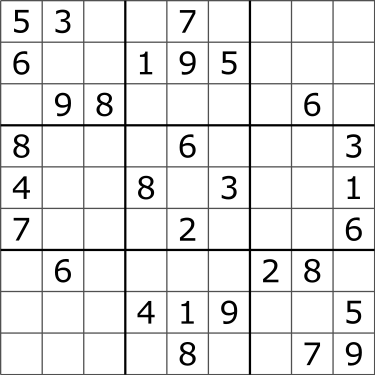

## Prepare environment

In [4]:
import kagglehub
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers, optimizers, losses, metrics, models, callbacks, regularizers
import pathlib
from matplotlib import pyplot as plt
import datetime
from sklearn.model_selection import StratifiedShuffleSplit
import shutil

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
# 
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
# keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

### Hyperparameters

In [5]:
DATA_SIZE_LIMIT = None

BATCH_SIZE = 128 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3
EPOCHS = 10

# Use residual connections in convolutional model architecture
USE_RESIDUAL = True

# Idea is to pretrain model on solution-only data (self-supervised learning) like autoencoder
#
# There is no performance improvement on small data sample (10%) and few epochs training (1)
# Turn on when training with more data and epochs to see if it helps
USE_PRE_TRAINING = False

## Prepare dataset

### Download from Kaggle

In [6]:
path = kagglehub.dataset_download("rohanrao/sudoku")
print("Path to dataset files:", path)

Path to dataset files: /home/martin/.cache/kagglehub/datasets/rohanrao/sudoku/versions/1


In [7]:
os.listdir(path)

['sudoku.csv']

In [8]:
FILE_PATH = os.path.join(path, "sudoku.csv")

In [9]:
sudoku_text = pathlib.Path(FILE_PATH).read_text()

In [10]:
sudoku_lines = sudoku_text.split("\n")[1:-1]  # Drop header

del sudoku_text

In [11]:
if (DATA_SIZE_LIMIT != None):
    sudoku_lines = sudoku_lines[:DATA_SIZE_LIMIT]

In [12]:
full_dataset_size = len(sudoku_lines)
print(full_dataset_size)

9000000


### Decode CSV to tensor list

In [13]:
sudoku_tensors = np.array(tf.io.decode_csv(sudoku_lines, record_defaults=[str()] * 2))
print(f"Decoded CSV shape: {sudoku_tensors.shape}")

del sudoku_lines

I0000 00:00:1745561103.898511   14922 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Decoded CSV shape: (2, 9000000)


### Split train, validation and test sets based on difficulty

In [14]:
X_tensors, y_tensors = sudoku_tensors

In [15]:
def calculate_difficulties(X_tensors):
    # Count zero entries (given clues) - the more zeros the more difficult is the puzzle
    difficulties = np.array([puzzle.decode("utf-8").count("0") for puzzle in X_tensors])
    return difficulties

In [16]:
difficulties = calculate_difficulties(X_tensors)

# Replace difficulties with rare occurrence with the most common one so that we can split evenly
difficulty_counts = np.bincount(difficulties)
rare_difficulties = np.where(difficulty_counts < 10)[0]
most_common_difficulty = np.argmax(difficulty_counts)
difficulties = np.where(np.isin(difficulties, rare_difficulties), most_common_difficulty, difficulties)

print("Original difficulty distribution:", np.bincount(difficulties))

Original difficulty distribution: [     0      0      0      0      0     11     25     72    103    188
    282    456    642   1044   1390   1922   2619   3584   4825   6558
   8405  11128  14376  18327  23417  29746  37918  47977  59119  73584
  90280 110194 133085 160784 193094 228562 269619 315259 364182 415920
 470816 523576 573332 614257 642208 650818 635339 591077 517507 424195
 314756 208498 118817  56760  21546   6304   1297    182     18]


In [17]:
train_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(train_sss.split(X_tensors, difficulties))
difficulties_train = difficulties[train_index]
difficulties_train_dist = np.round(100 * np.bincount(difficulties_train) / len(difficulties_train), 2)
print("Train difficulty distribution (percentage):", difficulties_train_dist)

X_train_tensors, X_temp, y_train_tensors, y_temp = X_tensors[train_index], X_tensors[test_index], y_tensors[train_index], y_tensors[test_index]
difficulties_temp = difficulties[test_index]

test_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(test_sss.split(X_temp, difficulties_temp))
X_val_tensors, X_test_tensors, y_val_tensors, y_test_tensors = X_temp[val_index], X_temp[test_index], y_temp[val_index], y_temp[test_index]

difficulties_val = difficulties_temp[val_index]
difficulties_val_dist = np.round(100 * np.bincount(difficulties_val) / len(difficulties_val), 2)
print("Val difficulty distribution (percentage):", difficulties_val_dist)

difficulties_test = difficulties_temp[test_index]
difficulties_test_dist = np.round(100 * np.bincount(difficulties_test) / len(difficulties_test), 2)
print("Test difficulty distribution (percentage):", difficulties_test_dist)

# Calculate the difference between the distributions
train_val_diff = difficulties_train_dist - difficulties_val_dist
train_test_diff = difficulties_train_dist - difficulties_test_dist
val_test_diff = difficulties_val_dist - difficulties_test_dist

# Print the differences
print("Difference between train and validation difficulty distribution (percentage):", train_val_diff)
print("Difference between train and test difficulty distribution (percentage):", train_test_diff)
print("Difference between validation and test difficulty distribution (percentage):", val_test_diff)

del X_tensors, y_tensors, X_temp, y_temp


Train difficulty distribution (percentage): [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01
 0.02 0.02 0.03 0.04 0.05 0.07 0.09 0.12 0.16 0.2  0.26 0.33 0.42 0.53
 0.66 0.82 1.   1.22 1.48 1.79 2.15 2.54 3.   3.5  4.05 4.62 5.23 5.82
 6.37 6.83 7.14 7.23 7.06 6.57 5.75 4.71 3.5  2.32 1.32 0.63 0.24 0.07
 0.01 0.   0.  ]
Val difficulty distribution (percentage): [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01
 0.02 0.02 0.03 0.04 0.05 0.07 0.09 0.12 0.16 0.2  0.26 0.33 0.42 0.53
 0.66 0.82 1.   1.22 1.48 1.79 2.15 2.54 3.   3.5  4.05 4.62 5.23 5.82
 6.37 6.82 7.14 7.23 7.06 6.57 5.75 4.71 3.5  2.32 1.32 0.63 0.24 0.07
 0.01 0.   0.  ]
Test difficulty distribution (percentage): [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01
 0.02 0.02 0.03 0.04 0.05 0.07 0.09 0.12 0.16 0.2  0.26 0.33 0.42 0.53
 0.66 0.82 1.   1.22 1.48 1.79 2.15 2.54 3.   3.5  4.05 4.62 5.23 5.82
 6.37 6.83 7.14 7.23 7.06 6.57 5.75 4.71 3.5  2.32 1.32 

#### Validate splits

In [18]:
train_difficulty_10_sample = X_train_tensors[np.where(difficulties_train == 10)[0]][:5]
print(train_difficulty_10_sample)

[puzzle.decode("utf-8").count("0") for puzzle in train_difficulty_10_sample]

[b'742136859168759432593842601659371208827690305304205967036027184285403796471968503'
 b'305746200204019635961523487657180309492637518810052746548271963739468152126395804'
 b'786945213402670895935080467150498700649752008278316549864137952521860374397524681'
 b'769241385431658729582790461648972503127536948395804206916025837054367092073189600'
 b'485309721729001503163752948954008217832174650607295804071946382348527196296813475']


[10, 10, 10, 10, 10]

In [19]:
val_difficulty_20_sample = X_val_tensors[np.where(difficulties_val == 20)[0]][:5]
print(val_difficulty_20_sample)

[puzzle.decode("utf-8").count("0") for puzzle in val_difficulty_20_sample]

[b'674085021982630500351724086260803159405260837039517642023498065008100293006352018'
 b'035040172401326985982170634500612890203007541098053267059034716700568009320791458'
 b'280109675005600410761405830850394061679518243143270008510942386038761000426853097'
 b'021849673870010590034076018108650329000021807752083146613294785295030400487165932'
 b'020197360051486729690320814030910657710630948906758231170003586563001492280069073']


[20, 20, 20, 20, 20]

In [20]:
test_difficulty_30_sample = X_test_tensors[np.where(difficulties_test == 30)[0]][:5]
print(test_difficulty_30_sample)

[puzzle.decode("utf-8").count("0") for puzzle in test_difficulty_30_sample]

[b'403080752721005800005000391957032164042006503310057920164508009209040085500269410'
 b'075096148934701526816520970400603092001400085097000614009065830000930457583007200'
 b'891706532326000401050320896030070060000014723470039100048960300217403609963187005'
 b'540029300129005046038000209094603520072598164005247903003071698007300412061002705'
 b'091203057530170629872009030908300010260081300013067208006800972709032501120796480']


[30, 30, 30, 30, 30]

In [21]:
print(f"Train size: {len(X_train_tensors)}")
print(f"Validation size: {len(X_val_tensors)}")
print(f"Test size: {len(X_test_tensors)}")

Train size: 7200000
Validation size: 900000
Test size: 900000


### Sort train set by difficulty

In [22]:
def apply_curriculum_learning(X_tensors, y_tensors):
    # Sort data by increasing difficulty
    sorted_indices = np.argsort(difficulties_train)
    X_tensors_sorted = X_tensors[sorted_indices]
    y_tensors_sorted = y_tensors[sorted_indices]
    return X_tensors_sorted, y_tensors_sorted

In [23]:
# Sorted by difficulty (from easier to harder)
X_train_tensors_sorted, y_train_tensors_sorted = apply_curriculum_learning(X_train_tensors, y_train_tensors)

In [24]:
X_train_tensors_sorted[:5]

array([b'362589471781430956954176328130928547807645139490713082643297815578361294219854763',
       b'467350089128479365093862047251736498684195732379048516842917653915623874736584921',
       b'048350692092641538360289147621893475530164289984572316416728953859436721273915864',
       b'082376490406152738173498260358261904947583126261947853625819347834725619719634582',
       b'687213549132495786495876132209381075758964213301752698976508321524130867813627954'],
      dtype=object)

In [25]:
X_train_tensors_sorted[-5:]

array([b'540000036021030008000000000050009040000080103000000020800670005000200400003100000',
       b'000908000390070005005000097000009000026000000700035102070000509040200000000000060',
       b'140090076003000100000002503039000000000000402700603000000100060020800000000000095',
       b'000300000009081040003000502050068000200000709734000000000040000010005000008000301',
       b'060002008000900072300000006000010000020004809056000000070000051200068000000035000'],
      dtype=object)

In [26]:
val_sudoku_ds = tf.data.Dataset.from_tensor_slices((X_val_tensors, y_val_tensors))
test_sudoku_ds = tf.data.Dataset.from_tensor_slices((X_test_tensors, y_test_tensors))

In [27]:
for puzzle, solution in val_sudoku_ds.take(1):
    print(puzzle, solution)

tf.Tensor(b'008003000200000008600001400070090021061008030800300050056147083000500100104900700', shape=(), dtype=string) tf.Tensor(b'718423596245769318639851472473695821561278934892314657956147283327586149184932765', shape=(), dtype=string)


2025-04-25 08:05:46.902978: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Preprocess

In [28]:
@tf.function
def preprocess(puzzle_tensor):
    puzzle_chars = tf.strings.bytes_split(puzzle_tensor)
    puzzle_numbers = tf.strings.to_number(puzzle_chars, out_type=tf.int32)
    return tf.reshape(puzzle_numbers, (9, 9, 1))

@tf.function
def preprocess_input(puzzle_tensor):
    return (preprocess(puzzle_tensor) / 9) - 0.5

@tf.function
def preprocess_target(puzzle_tensor):
    return preprocess(puzzle_tensor) - 1 # 0-based predictions (when presenting results, do not forget to add +1)

In [29]:
val_sudoku_preprocessed_ds = val_sudoku_ds.map(lambda X, y: (preprocess_input(X), preprocess_target(y)), num_parallel_calls=tf.data.AUTOTUNE)
test_sudoku_preprocessed_ds = test_sudoku_ds.map(lambda X, y: (preprocess_input(X), preprocess_target(y)), num_parallel_calls=tf.data.AUTOTUNE)

In [30]:
for row in val_sudoku_preprocessed_ds.take(1):
    print(f"{len(row), len(row[0]), len(row[0][0])}\n")
    print(f"puzzle:\n{row[0]}\n")
    print(f"solution:\n{row[1]}\n")

(2, 9, 9)

puzzle:
[[[-0.5       ]
  [-0.5       ]
  [ 0.38888889]
  [-0.5       ]
  [-0.5       ]
  [-0.16666667]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]]

 [[-0.27777778]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [ 0.38888889]]

 [[ 0.16666667]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.38888889]
  [-0.05555556]
  [-0.5       ]
  [-0.5       ]]

 [[-0.5       ]
  [ 0.27777778]
  [-0.5       ]
  [-0.5       ]
  [ 0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.27777778]
  [-0.38888889]]

 [[-0.5       ]
  [ 0.16666667]
  [-0.38888889]
  [-0.5       ]
  [-0.5       ]
  [ 0.38888889]
  [-0.5       ]
  [-0.16666667]
  [-0.5       ]]

 [[ 0.38888889]
  [-0.5       ]
  [-0.5       ]
  [-0.16666667]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [ 0.05555556]
  [-0.5       ]]

 [[-0.5       ]
  [ 0.05555556]
  [ 0.16666667]
  [-0.38888889]
  [-0.05555556]
  [ 0.27777778]
  [-0.5  

2025-04-25 08:05:47.259507: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Build input pipeline for performance

In [31]:
CACHE_DIR = "cache"

# Clear any cache from previous runs
shutil.rmtree(CACHE_DIR, ignore_errors=True)

# Prepare
os.mkdir(CACHE_DIR)

In [32]:
def configure_for_performance(ds, shuffle, cache_dir = None):
  if (cache_dir != None):
    # if memory is not an issue, do not specify disk folder so that everything is loaded to memory
    # ds = ds.cache(os.path.join(CACHE_DIR, cache_dir))
    ds = ds.cache()
  if (shuffle):
    ds = ds.shuffle(buffer_size=100_000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [33]:
val_dataset = configure_for_performance(val_sudoku_preprocessed_ds, cache_dir="val", shuffle=False)
test_dataset = configure_for_performance(test_sudoku_preprocessed_ds, shuffle=False)

del val_sudoku_preprocessed_ds, test_sudoku_preprocessed_ds

In [34]:
for X_batch, y_batch in test_dataset.take(1):
    for X, y in zip(X_batch, y_batch):
        print(((X + 0.5) * 9).numpy().reshape((9, 9)))
        print((y + 1).numpy().reshape((9, 9)))
        break

[[0. 6. 0. 0. 8. 1. 5. 0. 0.]
 [8. 0. 0. 0. 5. 9. 1. 0. 0.]
 [9. 5. 0. 3. 6. 0. 7. 0. 0.]
 [0. 4. 0. 8. 0. 0. 9. 0. 1.]
 [0. 8. 0. 1. 9. 7. 2. 4. 6.]
 [0. 0. 0. 0. 4. 0. 8. 7. 0.]
 [0. 7. 0. 4. 1. 0. 6. 0. 0.]
 [4. 1. 0. 0. 0. 6. 0. 8. 0.]
 [5. 0. 6. 0. 2. 0. 0. 0. 0.]]
[[7 6 4 2 8 1 5 3 9]
 [8 2 3 7 5 9 1 6 4]
 [9 5 1 3 6 4 7 2 8]
 [6 4 7 8 3 2 9 5 1]
 [3 8 5 1 9 7 2 4 6]
 [1 9 2 6 4 5 8 7 3]
 [2 7 8 4 1 3 6 9 5]
 [4 1 9 5 7 6 3 8 2]
 [5 3 6 9 2 8 4 1 7]]


## Train model

In [35]:
inputs = layers.Input((9, 9, 1))

# Initial feature extraction
x = layers.Conv2D(64, kernel_size=3, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Residual blocks for deeper learning
if USE_RESIDUAL:
    for _ in range(1):  # Multiple residual blocks to improve feature extraction
        residual = x
        x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        # Skip connection
        x = layers.Add()([x, residual])
        x = layers.Activation("relu")(x)
else:
    # Alternative deeper network without residual connections
    for _ in range(2):
        x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

# Increase feature capacity with 1x1 convolutions
x = layers.Conv2D(128, kernel_size=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Incorporate Sudoku structure awareness
# Row awareness
row_conv = layers.Conv2D(32, kernel_size=(1, 9), padding="same")(x)
# Column awareness  
col_conv = layers.Conv2D(32, kernel_size=(9, 1), padding="same")(x)
# Box awareness (3x3 boxes with dilation)
box_conv = layers.Conv2D(32, kernel_size=3, padding="same", dilation_rate=3)(x)

# Combine structure-aware features
x = layers.Concatenate()([x, row_conv, col_conv, box_conv])
x = layers.Conv2D(64, kernel_size=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
    
# Final prediction layers
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(9 * 9 * 9, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Reshape((9, 9, 9))(x)
outputs = layers.Softmax()(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(LEARNING_RATE),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 128) │      8,320 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 9, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 32)  │     36,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 9, 9, 32)  │     36,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 9, 9, 32)  │     36,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 9, 9, 224) │          0 │ activation_3[0][… │
│ (Concatenate)       │                   │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,989,305 (15.22 MB)

 Trainable params: 3,988,537 (15.22 MB)

 Non-trainable params: 768 (3.00 KB)

In [36]:
LOGS_DIR = "logs"
# Clear any logs from previous runs
shutil.rmtree(LOGS_DIR, ignore_errors=True)

MODEL_CHECKPOINT_NAME = "sudoku_model_checkpoint.keras"
# Clear any model checkpoint (those are only useful in case training stops abruptly)
if os.path.exists(MODEL_CHECKPOINT_NAME):
    os.remove(MODEL_CHECKPOINT_NAME)

def prepare_callbacks():
    return [
        callbacks.ModelCheckpoint(
            MODEL_CHECKPOINT_NAME, save_best_only=True, monitor="val_accuracy"
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
        ),
        callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        callbacks.TensorBoard(
            log_dir=os.path.join(LOGS_DIR, "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
            histogram_freq=1,
            update_freq=1000,
        ),
    ]

### Pre-train on solutions only

In [37]:
if (USE_PRE_TRAINING):
    pretrain_model = models.clone_model(model)

    training_callbacks = prepare_callbacks()

    # Pre-train dataset
    pretrain_sudoku_ds = tf.data.Dataset.from_tensor_slices(
        # Learn basic rules only on solutions
        (y_train_tensors, y_train_tensors)
    )
    # Rest is same as during training
    pretrain_sudoku_reshaped_ds = pretrain_sudoku_ds.map(
        lambda X, y: (preprocess_input(X), preprocess_target(y)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    pretrain_dataset = configure_for_performance(pretrain_sudoku_reshaped_ds, cache_dir="pretrain", shuffle=True)

    # Pre-train val dataset
    pretrain_val_sudoku_ds = tf.data.Dataset.from_tensor_slices(
        # Learn basic rules only on solutions
        (y_val_tensors, y_val_tensors)
    )
    # Rest is same as during training
    pretrain_val_sudoku_reshaped_ds = pretrain_val_sudoku_ds.map(
        lambda X, y: (preprocess_input(X), preprocess_target(y)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    pretrain_val_dataset = configure_for_performance(pretrain_val_sudoku_reshaped_ds, cache_dir="pretrain_val", shuffle=True)

    # Train
    pretrain_history = pretrain_model.fit(
        pretrain_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=pretrain_val_dataset,
        callbacks=training_callbacks
    )

    del pretrain_sudoku_ds, pretrain_sudoku_reshaped_ds, pretrain_dataset

    # Transfer learned weights to our actual model
    # (we only transfer convolutional layers, not the final dense layer)
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.BatchNormalization):
            model.layers[i].set_weights(pretrain_model.layers[i].get_weights())

    del pretrain_model        

In [38]:
del X_train_tensors, y_train_tensors, X_val_tensors, y_val_tensors, X_test_tensors, y_test_tensors

### Train progressively with increasing dataset sizes

In [39]:
# Include some percentage of earlier samples in each new batch
def create_mixed_dataset(x_data, y_data, prev_indices, new_indices, mix_ratio=0.2):
    # Sample some previous examples
    num_prev = int(len(new_indices) * mix_ratio)
    if num_prev > 0 and len(prev_indices) > 0:
        sampled_prev = np.random.choice(prev_indices, size=min(num_prev, len(prev_indices)), replace=False)
        combined_indices = np.concatenate([sampled_prev, new_indices])
    else:
        combined_indices = new_indices
        
    return x_data[combined_indices], y_data[combined_indices]

In [40]:
# Percentage of data set to use
data_size_per = [0.05, 0.1, 0.2, 0.5, 1]

training_callbacks = prepare_callbacks()

# Progressive training
prev_size = 0
history_list = []
for percentage in data_size_per:
    # Calculate how many samples to use
    n_samples = int(percentage * full_dataset_size)
    # Don't exceed available training samples
    n_samples = min(n_samples, len(X_train_tensors_sorted))
    print(
        f"\n{percentage*100}% of samples included in training, however training only with new {n_samples - prev_size} samples..."
    )

    # Get subset of training data
    X_train_current = X_train_tensors_sorted[prev_size:n_samples]
    y_train_current = y_train_tensors_sorted[prev_size:n_samples]

    train_sudoku_ds = tf.data.Dataset.from_tensor_slices(
        (X_train_current, y_train_current)
    )
    train_sudoku_reshaped_ds = train_sudoku_ds.map(
        lambda X, y: (preprocess_input(X), preprocess_target(y)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    train_dataset = configure_for_performance(train_sudoku_reshaped_ds, cache_dir="train", shuffle=True)

    del X_train_current
    del y_train_current

    # Adjust learning rate based on dataset size
    if percentage <= 0.1:
        lr = 1e-3
    elif percentage <= 0.5:
        lr = 5e-4
    else:
        lr = 1e-4

    # Update optimizer learning rate
    model.optimizer.learning_rate = lr

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=training_callbacks,
    )
    history_list.append(history)

    del train_sudoku_ds
    del train_sudoku_reshaped_ds
    del train_dataset

    # Update previous size for next iteration
    prev_size = n_samples

model.save(MODEL_FILE_NAME)


5.0% of samples included in training, however training only with new 450000 samples...
Epoch 1/10


I0000 00:00:1745561159.458059   15259 service.cc:148] XLA service 0x7fe6b801a820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745561159.458557   15259 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-04-25 08:05:59.582866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1745561159.871601   15259 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1745561160.178693   15259 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-04-25 08:06:01.230610: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[128,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,

3514/3516 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6584 - loss: 1.0613

W0000 00:00:1745561313.477434   15260 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-04-25 08:08:34.113774: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[80,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[80,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-25 08:08:35.189637: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[720,32,3,3]{3,2,1,0}, u8[0]{0}) custom

3516/3516 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6585 - loss: 1.0611

W0000 00:00:1745561322.345096   15256 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1745561404.579043   15260 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-04-25 08:10:04.768729: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-25 0

3516/3516 ━━━━━━━━━━━━━━━━━━━━ 257s 67ms/step - accuracy: 0.6586 - loss: 1.0609 - val_accuracy: 0.7942 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 2/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9286 - loss: 0.3492

2025-04-25 08:13:47.411377: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 906992640 exceeds 10% of free system memory.


3516/3516 ━━━━━━━━━━━━━━━━━━━━ 220s 62ms/step - accuracy: 0.9286 - loss: 0.3492 - val_accuracy: 0.7978 - val_loss: 0.6733 - learning_rate: 0.0010
Epoch 3/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9325 - loss: 0.3383

2025-04-25 08:17:26.862242: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 906992640 exceeds 10% of free system memory.


3516/3516 ━━━━━━━━━━━━━━━━━━━━ 219s 62ms/step - accuracy: 0.9325 - loss: 0.3383 - val_accuracy: 0.8000 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 4/10
3515/3516 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9353 - loss: 0.3290

2025-04-25 08:21:11.398204: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 906992640 exceeds 10% of free system memory.


3516/3516 ━━━━━━━━━━━━━━━━━━━━ 225s 64ms/step - accuracy: 0.9353 - loss: 0.3290 - val_accuracy: 0.8016 - val_loss: 0.6636 - learning_rate: 0.0010
Epoch 5/10
3515/3516 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9371 - loss: 0.3233

2025-04-25 08:24:53.988376: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 906992640 exceeds 10% of free system memory.


3516/3516 ━━━━━━━━━━━━━━━━━━━━ 223s 63ms/step - accuracy: 0.9371 - loss: 0.3233 - val_accuracy: 0.8025 - val_loss: 0.6618 - learning_rate: 0.0010
Epoch 6/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 220s 62ms/step - accuracy: 0.9382 - loss: 0.3203 - val_accuracy: 0.8048 - val_loss: 0.6569 - learning_rate: 0.0010
Epoch 7/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 219s 62ms/step - accuracy: 0.9391 - loss: 0.3174 - val_accuracy: 0.8056 - val_loss: 0.6542 - learning_rate: 0.0010
Epoch 8/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 221s 63ms/step - accuracy: 0.9401 - loss: 0.3139 - val_accuracy: 0.8069 - val_loss: 0.6520 - learning_rate: 0.0010
Epoch 9/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 219s 62ms/step - accuracy: 0.9418 - loss: 0.3088 - val_accuracy: 0.8074 - val_loss: 0.6499 - learning_rate: 0.0010
Epoch 10/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 221s 63ms/step - accuracy: 0.9422 - loss: 0.3075 - val_accuracy: 0.8085 - val_loss: 0.6465 - learning_rate: 0.0010

10.0% of samples included in training, however training only with n

W0000 00:00:1745565896.005597   15258 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


7032/7032 ━━━━━━━━━━━━━━━━━━━━ 377s 53ms/step - accuracy: 0.8814 - loss: 0.4365 - val_accuracy: 0.8289 - val_loss: 0.5200 - learning_rate: 5.0000e-04
Epoch 2/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 358s 51ms/step - accuracy: 0.8838 - loss: 0.4116 - val_accuracy: 0.8298 - val_loss: 0.5185 - learning_rate: 5.0000e-04
Epoch 3/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 358s 51ms/step - accuracy: 0.8844 - loss: 0.4099 - val_accuracy: 0.8298 - val_loss: 0.5176 - learning_rate: 5.0000e-04
Epoch 4/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 359s 51ms/step - accuracy: 0.8848 - loss: 0.4089 - val_accuracy: 0.8305 - val_loss: 0.5164 - learning_rate: 5.0000e-04
Epoch 5/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 358s 51ms/step - accuracy: 0.8853 - loss: 0.4079 - val_accuracy: 0.8305 - val_loss: 0.5161 - learning_rate: 5.0000e-04
Epoch 6/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 358s 51ms/step - accuracy: 0.8856 - loss: 0.4071 - val_accuracy: 0.8304 - val_loss: 0.5149 - learning_rate: 5.0000e-04
Epoch 7/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 358

W0000 00:00:1745570096.365396   15260 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-04-25 10:34:57.183601: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[96,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-25 10:34:58.136709: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[864,32,3,3]{3,2,1,0}, u8[0]{0}) custom

21094/21094 ━━━━━━━━━━━━━━━━━━━━ 957s 45ms/step - accuracy: 0.8373 - loss: 0.5280 - val_accuracy: 0.8327 - val_loss: 0.5137 - learning_rate: 5.0000e-04
Epoch 2/10
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 924s 44ms/step - accuracy: 0.8382 - loss: 0.5252 - val_accuracy: 0.8327 - val_loss: 0.5139 - learning_rate: 5.0000e-04
Epoch 3/10
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 922s 44ms/step - accuracy: 0.8389 - loss: 0.5235 - val_accuracy: 0.8332 - val_loss: 0.5123 - learning_rate: 5.0000e-04
Epoch 4/10
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 922s 44ms/step - accuracy: 0.8395 - loss: 0.5221 - val_accuracy: 0.8350 - val_loss: 0.5089 - learning_rate: 5.0000e-04
Epoch 5/10
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 923s 44ms/step - accuracy: 0.8400 - loss: 0.5209 - val_accuracy: 0.8344 - val_loss: 0.5096 - learning_rate: 5.0000e-04
Epoch 6/10
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 4933s 234ms/step - accuracy: 0.8405 - loss: 0.5199 - val_accuracy: 0.8352 - val_loss: 0.5076 - learning_rate: 5.0000e-04
Epoch 7/10
21094/21094 ━━━━━━━━

## Evaluate model

### Plot training history as learning curves

In [41]:
merged_histories = history_list[0].history
for history in history_list[1:]:
    current_history = history.history
    for key in current_history.keys():
        merged_histories[key] += current_history[key]

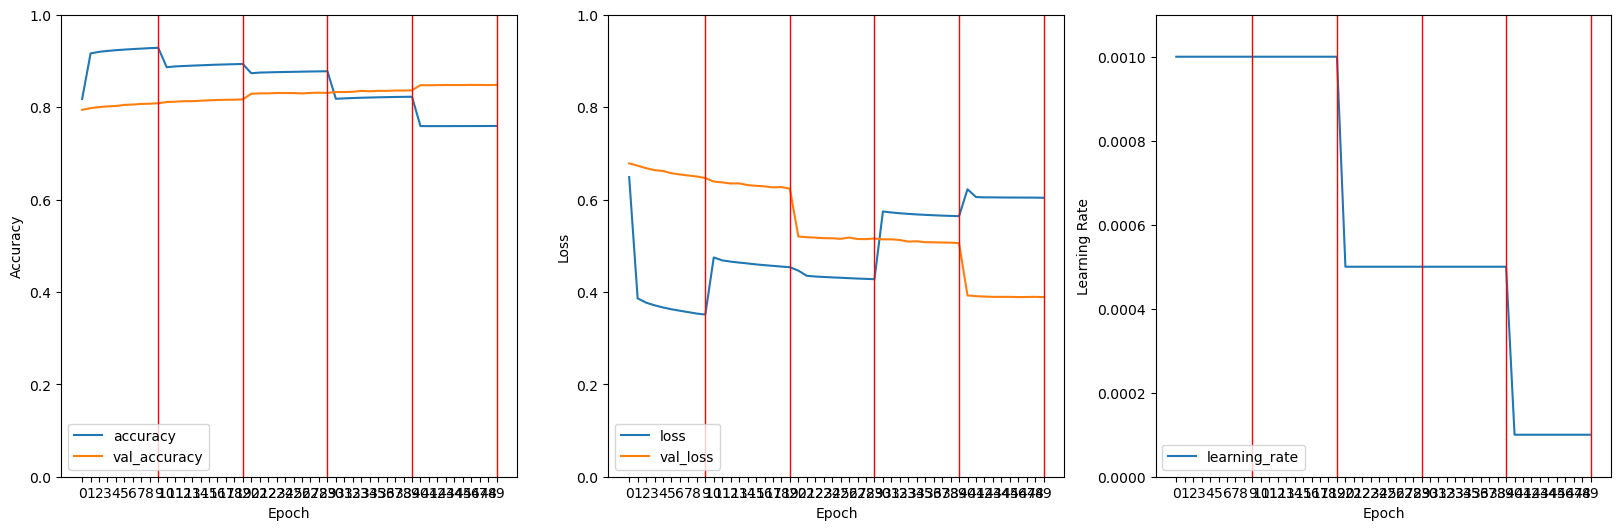

In [53]:
n_epochs = len(merged_histories["loss"])
x_ticks = np.arange(0, n_epochs, 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(merged_histories["accuracy"], label="accuracy")
plt.plot(merged_histories["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.xticks(x_ticks)
plt.legend(loc="lower left")
for index, tick in enumerate(x_ticks):
    if ((index + 1) % EPOCHS == 0):
        plt.vlines(x=tick, ymin=0, ymax=10, color='r', linestyle='-', linewidth=1)

plt.subplot(1, 3, 2)
plt.plot(merged_histories["loss"], label="loss")
plt.plot(merged_histories["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.xticks(x_ticks)
plt.legend(loc="lower left")
for index, tick in enumerate(x_ticks):
    if ((index + 1) % EPOCHS == 0):
        plt.vlines(x=tick, ymin=0, ymax=10, color='r', linestyle='-', linewidth=1)

plt.subplot(1, 3, 3)
plt.plot(merged_histories["learning_rate"], label="learning_rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.ylim([0, LEARNING_RATE + LEARNING_RATE / 10]) # Learning rate is a small float (overflowing) - to see start, add some to the top
plt.xticks(x_ticks)
plt.legend(loc="lower left")
for index, tick in enumerate(x_ticks):
    if ((index + 1) % EPOCHS == 0):
        plt.vlines(x=tick, ymin=0, ymax=10, color='r', linestyle='-', linewidth=1)

### Load model from disk to get reproducible results

In [43]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [44]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [45]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [46]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [47]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

2025-04-25 16:37:15.499888: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-25 16:37:16.245620: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[9,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,128,5,5]{3,2,1,0}, f32[32,128,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudn

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[8 9 6 2 5 9 7 1 4]
 [4 2 5 3 6 7 8 1 8]
 [7 7 1 4 7 8 2 6 5]
 [6 1 2 8 4 5 3 7 6]
 [9 5 4 6 7 3 1 9 7]
 [3 5 7 9 1 2 6 4 6]
 [5 4 8 7 9 9 6 2 3]
 [7 6 6 5 2 4 2 8 9]
 [2 7 9 5 8 6 4 4 1]]


In [48]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

W0000 00:00:1745591838.758296   15255 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7531 - loss: 0.6188


In [49]:
result = solve_sudoku(""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[4 2 2 5 1 9 6 3 7]
 [1 5 6 8 4 7 3 2 9]
 [3 7 6 8 2 9 5 4 1]
 [2 3 5 9 6 1 2 7 4]
 [6 7 7 4 8 3 2 1 5]
 [9 1 4 7 5 2 9 6 8]
 [8 6 8 1 7 5 1 9 3]
 [5 9 1 2 3 3 7 6 6]
 [7 4 3 1 9 8 1 5 2]]


In [50]:
puzzle = (""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
)

solution = (
    ""
    "482519637"
    "156347829"
    "379826541"
    "835961274"
    "627483915"
    "914752368"
    "268175493"
    "591234786"
    "743698152"
)

loss, accuracy = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8272 - loss: 0.4058


0.8271604776382446

### Evaluate test set performance

In [51]:
loss, accuracy = model.evaluate(test_dataset)

W0000 00:00:1745591840.972216   15256 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


7031/7032 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8481 - loss: 0.3887

W0000 00:00:1745591937.543907   15257 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


7032/7032 ━━━━━━━━━━━━━━━━━━━━ 98s 14ms/step - accuracy: 0.8481 - loss: 0.3887


In [52]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.8480881452560425 and loss: 0.3888397216796875


The End